In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse

import src.cfg as cfg
import src.data as data
import src.models as models
import src.processing as processing
import src.filters as fltr
from src.viz import Plot

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams["date.autoformatter.year"] = "%Y"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.style.use('seaborn-whitegrid')
from mpl_toolkits.basemap import Basemap

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from livelossplot import PlotLossesKeras
from IPython.display import clear_output
clear_output(wait=True)

Using TensorFlow backend.


In [2]:
def apply2dmask(array3d, mask2d):
    mask = np.broadcast_to(mask2d, array3d.shape)
    array3d[mask]=np.nan
    res = array3d
    return res
land_mask = np.load('../data/meta/mask.npy', allow_pickle=True)
#land_mask[land_mask==0] = np.nan

In [13]:
parameters = dict(years_train=list(range(2010, 2014)),
                  years_test=[2014],
                  X_vars=['icethic_cea', 'vosaline'],
                  y_var='hice',
                  bounds=[0, 400, 0, 400]
                  )

y_arr_train, X_arr_train = data.load_features(parameters['y_var'],
                                              parameters['X_vars'],
                                              parameters['years_train'])

y_arr_test, X_arr_test = data.load_features(parameters['y_var'],
                                            parameters['X_vars'],
                                            parameters['years_test'])

X_train = np.array(X_arr_train)
y_train = np.array(y_arr_train)
X_train=np.moveaxis(X_train,0,-1)

X_test = np.array(X_arr_test)
y_test = np.array(y_arr_test)
X_test=np.moveaxis(X_test,0,-1)

KeyboardInterrupt: 

In [ ]:
def apply2dmask(array3d, mask2d):
    mask = np.broadcast_to(mask2d, array3d.shape)
    array3d[mask]=np.nan
    res = array3d
    return res
land_mask = np.load('/content/drive/My Drive/data/mask.npy', allow_pickle=True)

def preprocess_Xarray(array):
    for i in range(array.shape[-1]):
    array[:,:,:,i] = apply2dmask(array[:,:,:,i], land_mask)


    for i in range(array.shape[0]):
    for j in range(array.shape[-1]):
        array[i,:,:,j] = (array[i,:,:,j] - np.nanmean(array[i,:,:,j], axis=0))/np.nanstd(array[i,:,:,j], axis=0)

    padY = 32 - (array.shape[1] % 32)
    padX = 32 - (array.shape[2] % 32)
    array = np.pad(array, [(0,0),(0, padY), (0, padX),(0,0)], mode='constant', constant_values=np.nan)

    array[np.isnan(array)] = -1
    assert (array.shape[1])%32==0
    assert (array.shape[2])%32==0

    return array

X_train_proc = preprocess_Xarray(X_train)
X_test_proc = preprocess_Xarray(X_test)
X_val_proc = preprocess_Xarray(X_val)


In [8]:
def preprocessYarray(array):
    array = apply2dmask(array[:,:,:,0], land_mask)

    padY = 32 - (array.shape[1] % 32)
    padX = 32 - (array.shape[2] % 32)
    array = np.pad(array, [(0,0),(0, padY), (0, padX)], mode='constant', constant_values=np.nan)
    array[np.isnan(array)] = -1
    return array[:,:,:,np.newaxis]
  
y_train_proc = preprocessYarray(y_train)
y_test_proc = preprocessYarray(y_test)
y_val_proc = preprocessYarray(y_val)


(1411, 452, 406, 2) (365, 452, 406, 2) (50, 452, 406, 2)


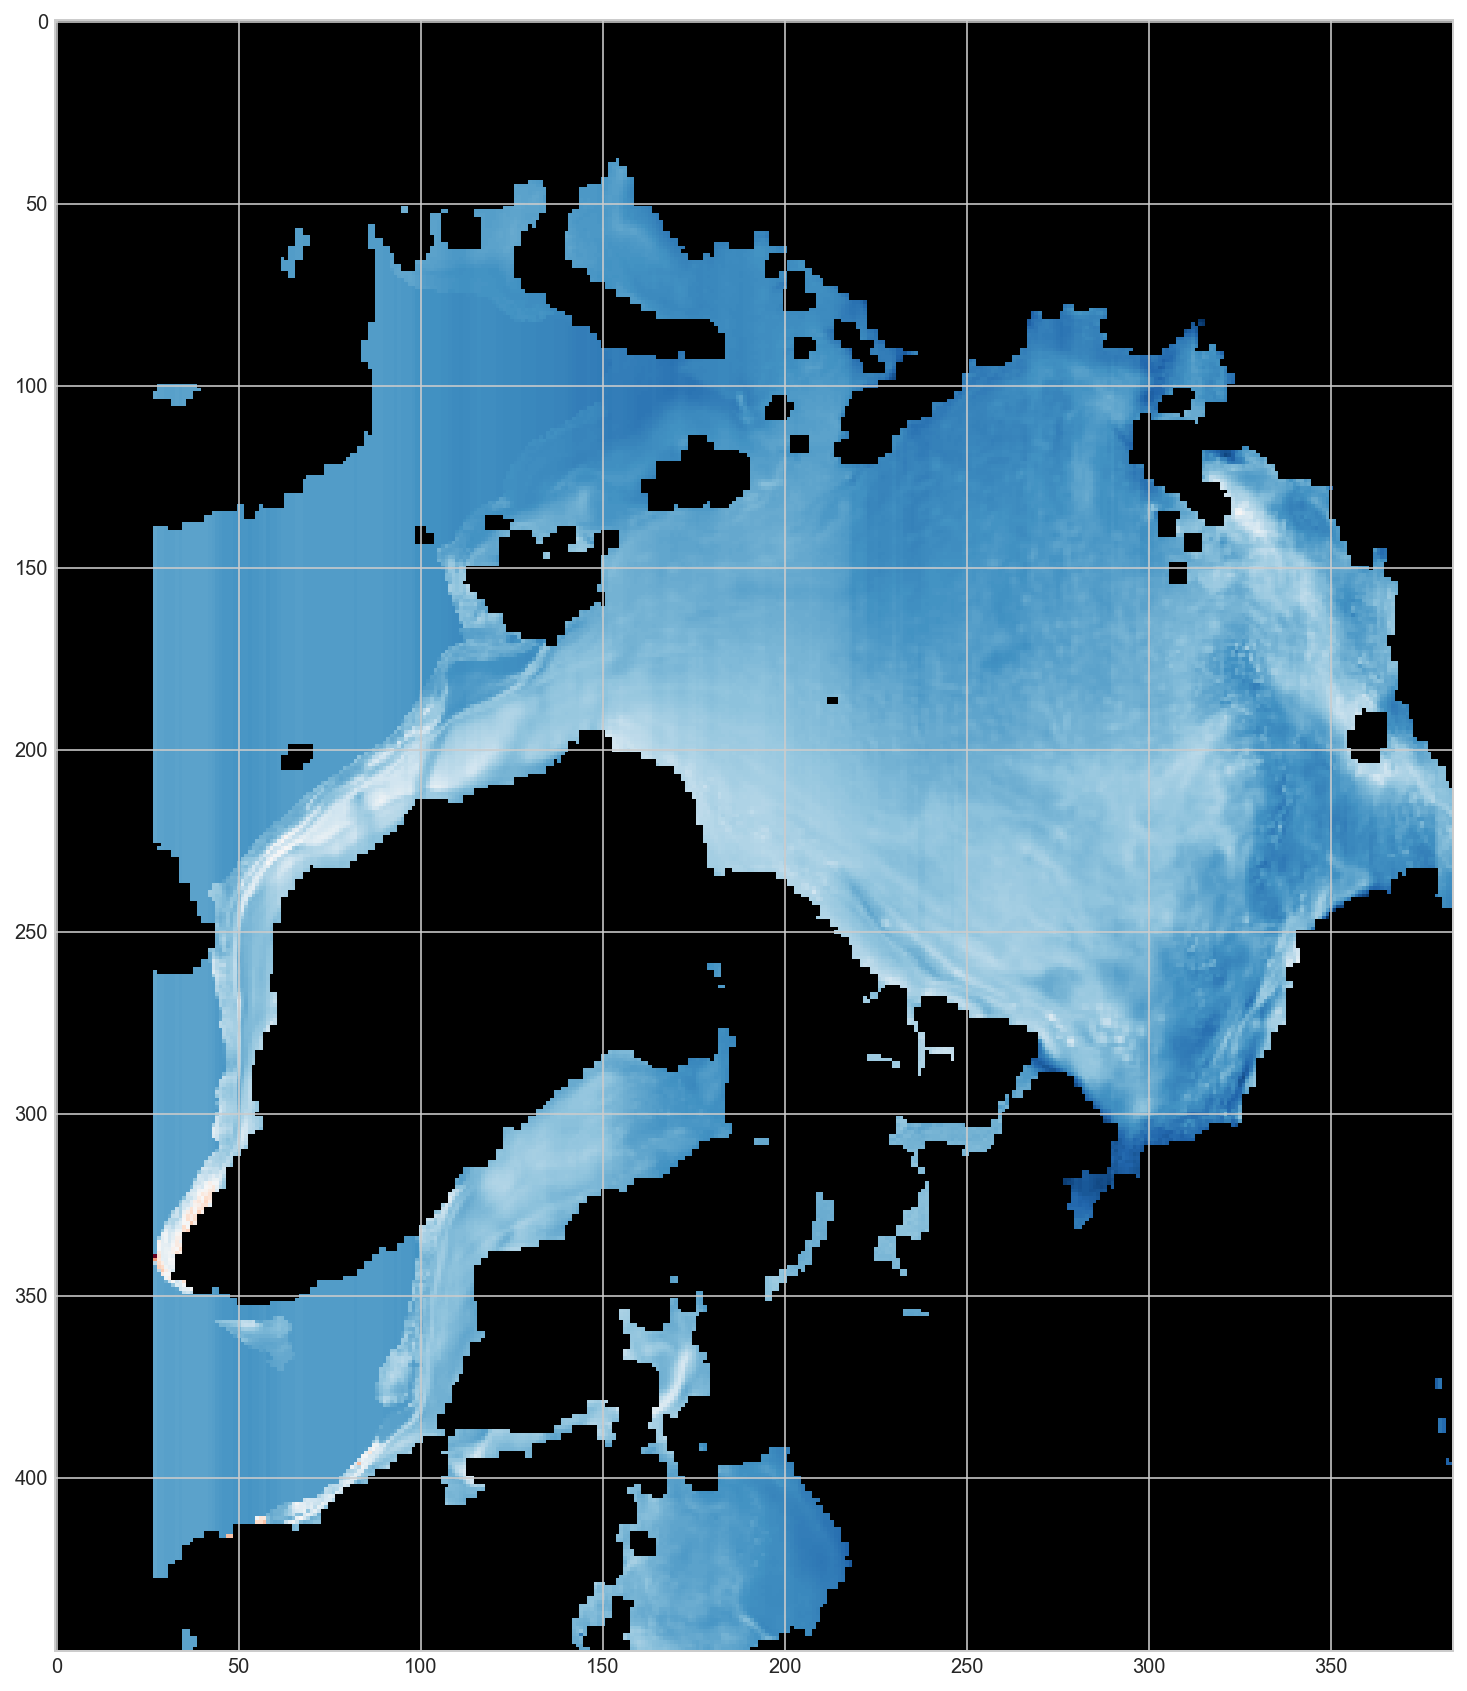

In [13]:
#plt.imshow(land_mask)
cmap = plt.get_cmap('RdBu_r')  # Can be any colormap that you want after the cm
cmap.set_bad(color='black')
plt.imshow(X_train[50,:,:,0], cmap=cmap)

In [31]:
out = []
for i in range(X_test.shape[0]):
    out.append(model.predict(X_test[np.newaxis,i, :,:,:]))
out = np.array(out)
out = np.reshape(out, (out.shape[0], out.shape[2], out.shape[3]))